In [1]:
import numpy as np # includes lots of useful maths funcitons
import matplotlib.pyplot as plt # package for plotting
import scipy.integrate as integrate # package for numerical integration
from scipy.special import gamma, factorial # gamma function and factorial
from scipy.stats import levy_stable # funciton to draw samples from stable paretian distribution
from scipy.stats import gaussian_kde # function for kernel-density estimate using Gaussian kernels 
from scipy.optimize import minimize #function to minimise callable function
import pandas as pd # for data manipulation and analysis

 # PART 1
 Choose two reasonably separated values of the tail index, say alpha_1 = 1.3, and alpha_2 = 1.7. Let X1 be the symmetric stable Paretian random variable (with location zero and scale 1) with alpha1; and X2 be the same, for alpha2; and these are *independent*. For a smart range of x-values (e.g., -8 to 8; but you check the plots and choose), compute:

In [2]:
alpha_1 = 1.3
alpha_2 = 1.7
x_grid = np.linspace(-10, 10, 1000) #larger grid for more accurate plotting
x_line = np.linspace(-10, 10, 100) # smaller grid for runtime improvement whilst still being sufficient

In [3]:
def cf_symmetric_stable_paretian(t, alpha):
    return np.exp(-abs(t) ** alpha)

### a) using the integral convolution formula (and a program to compute the pdf of the stable), the density of the convolution of X1 and X2, i.e., of S=X1+X2.

We use built in levy stable function.

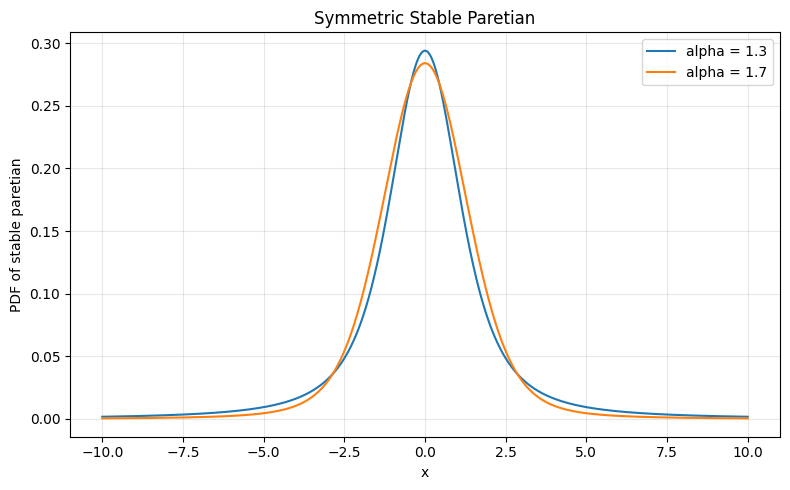

In [4]:
# compute cfs
phi_1 = levy_stable.pdf(x_grid, alpha_1, 0)
phi_2 = levy_stable.pdf(x_grid, alpha_2, 0)


# plot
plt.figure(figsize=(8, 5))
plt.plot(x_grid, phi_1, label=f'alpha = {alpha_1}')
plt.plot(x_grid, phi_2, label=f'alpha = {alpha_2}')
plt.xlabel('x')
plt.ylabel('PDF of stable paretian')
plt.title('Symmetric Stable Paretian')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Graph density of S = X1 + X2

In [5]:
def integrand(x1, s, alpha1, alpha2):
    return levy_stable.pdf(x1, alpha1, 0) * levy_stable.pdf(s - x1, alpha2, 0)

In [6]:
def convolution_pdf(s, alpha_1, alpha_2, integration_cutoff = np.inf):
    return integrate.quad(integrand, -integration_cutoff, integration_cutoff, args=(s, alpha_1, alpha_2))

In [7]:
# vectorise the function to run for multiple xs
conv_pdf_vec = np.vectorize(lambda s: convolution_pdf(s, alpha_1, alpha_2)[0])
 
# call the function for our x array
y = conv_pdf_vec(x_line)

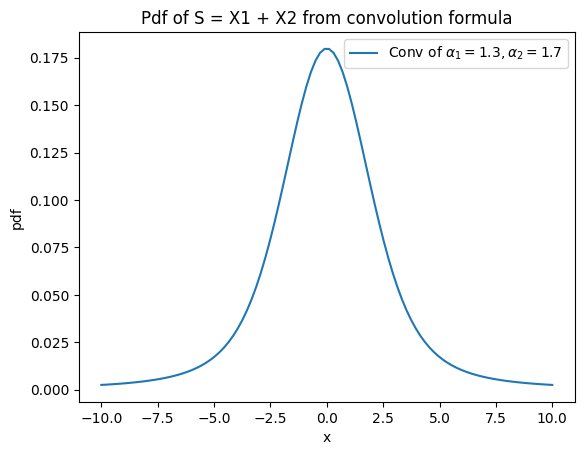

In [8]:
plt.plot(x_line, y,  label=f'Conv of $\\alpha_1={alpha_1}, \\alpha_2={alpha_2}$')
plt.title("Pdf of S = X1 + X2 from convolution formula")
plt.xlabel("x")
plt.ylabel("pdf")
plt.legend()

# Part b)

In [9]:
#seting the simulation number to large and drawing samples from the sum
sim_size = 10000000
sample_1 = levy_stable.rvs(alpha_1, 0, size = sim_size)
sample_2 = levy_stable.rvs(alpha_2, 0, size = sim_size)
# sum of the sampels drawn from each ditsribution
sample_convolution = sample_1 + sample_2

Text(0, 0.5, 'Frequency')

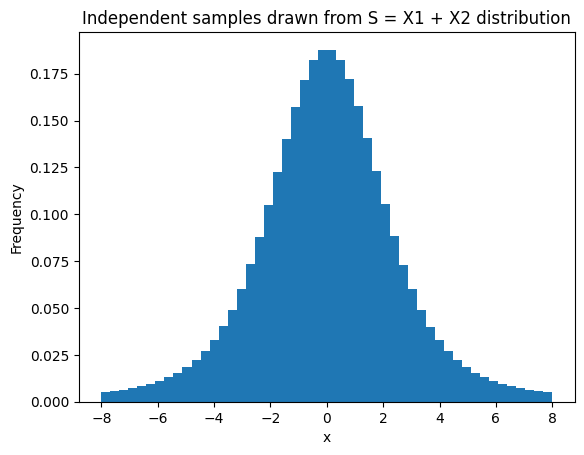

In [10]:
#cplotting histogram of the simulated samples
plt.hist(sample_convolution, bins = 50, range = (-8, 8), density=True)
plt.title("Independent samples drawn from S = X1 + X2 distribution")
plt.xlabel("x")
plt.ylabel("Frequency")

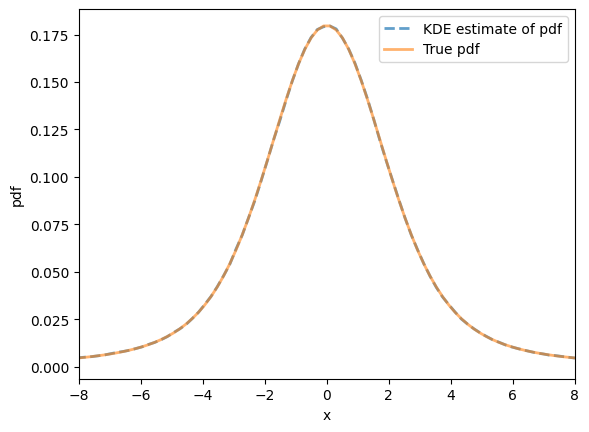

In [11]:
# Calling the kde function to fit the data
kde = gaussian_kde(sample_convolution, bw_method = 0.0005) 
# Bandwidth should be small because the variance is infinity, but we don't want to go too far to get a smooth kernel

# Evaluate on a grid
kde_vals = kde(x_line)

# Plot
plt.plot(x_line, kde_vals, label = 'KDE estimate of pdf', linestyle = '--', linewidth = 2, alpha = 0.7)
plt.plot(x_line, y, label = "True pdf", linestyle = '-', linewidth = 2, alpha = 0.6)
plt.xlabel("x")
plt.ylabel("pdf")
plt.xlim(right = 8) 
plt.xlim(left = -8) 
plt.legend()

plt.show()


# Part c

c) As X1 and X2 are independent, the characteristic function of the sum, S=X1+X2, is trivial. Use the inversion formula applied to the ch.f. of S to compute its density.

In [12]:
#function returning the product of the 2 cfs of X1 and X2 at point t, which is the cf of S = X1 + X2
def cf_s(t, alpha1, alpha2):
    return cf_symmetric_stable_paretian(t, alpha1) * cf_symmetric_stable_paretian(t, alpha2)

In [13]:
#callable returning the inversion formula
def integrand_inversion_formula(t, x, alpha1, alpha2):
    return np.cos(t * x) * cf_s(t, alpha1, alpha2)

In [14]:
#function returning pdf using inversion formula
def pdf_inversion_cf(x, alpha1, alpha2):
    # [0] because quad returns (integral, error)
    integral_val = integrate.quad(integrand_inversion_formula, -np.inf, np.inf, args = (x, alpha1, alpha2),limit= 100)[0] 
    return (1 / (2 * np.pi)) * integral_val

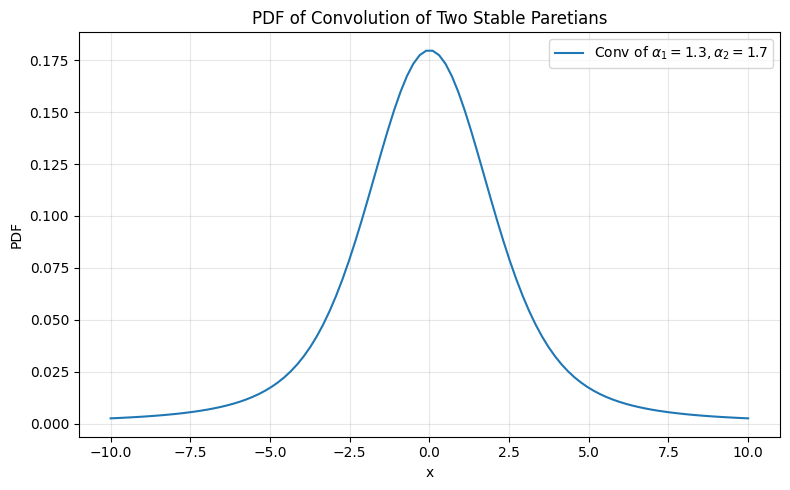

In [15]:
phi_1 = [pdf_inversion_cf(val, alpha_1, alpha_2) for val in x_line]

# plot
plt.figure(figsize=(8, 5))
plt.plot(x_line, phi_1, label=f'Conv of $\\alpha_1={alpha_1}, \\alpha_2={alpha_2}$')
plt.xlabel('x')
plt.ylabel('PDF')
plt.title('PDF of Convolution of Two Stable Paretians')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Part d)

Use the FFT to compute the density of the sum, based on its ch.f. For this, look at my book Intermediate Probability, I think chapter 2, for exactly the required codes to use the FFT to invert the ch.f. to get a density. This is for Matlab --- for Python, you can easily convert my Matlab codes.

In [16]:
#function that computes the pdf of S = X1 + X2 using FFT
def fft_density_calculation(alpha1, alpha2, N = 2**14, x_range = 20):
    L = x_range
    dx = (2 * L) / N
    x = np.arange(-L, L, dx)

    # The resolution in t is determined by the range in x via Heisenberg uncertainty principle of FFT
    dt = (2 * np.pi) / (N * dx)
    
    # We need t to be centered at 0, corresponding to x
    # But for calculation clarity, we generate a linear grid and will shift later
    t = np.arange(-N/2, N/2) * dt

    # The CF of a sum of independent variables is the product of their CFs
    vals_1 = cf_symmetric_stable_paretian(t, alpha1)
    vals_2 = cf_symmetric_stable_paretian(t, alpha2)
    cf_sum = vals_1 * vals_2

    # PDF(x) = (1/2pi) * Integral( e^(-itx) * phi(t) dt )
    # We use ifftshift to rearrange the array so t=0 is at index 0 (required for standard FFT)
    cf_shifted = np.fft.ifftshift(cf_sum)
    
    # Note: numpy's FFT computes sum(y * exp(-2pi...)). 
    # Because Stable distributions are symmetric, FFT and IFFT are essentially the same 
    # up to scaling factors. We use fft here.
    pdf_raw = np.fft.fft(cf_shifted)
    
    # Shift back so x=0 is in the middle of the array
    pdf_shifted = np.fft.fftshift(pdf_raw)
    
    # The discrete FFT outputs values that scale with N. 
    # We must normalize so that the area under the curve is 1.0. Area = sum(pdf) * dx
    current_area = np.sum(np.abs(pdf_shifted)) * dx
    pdf_final = np.abs(pdf_shifted) / current_area
    
    return x, pdf_final

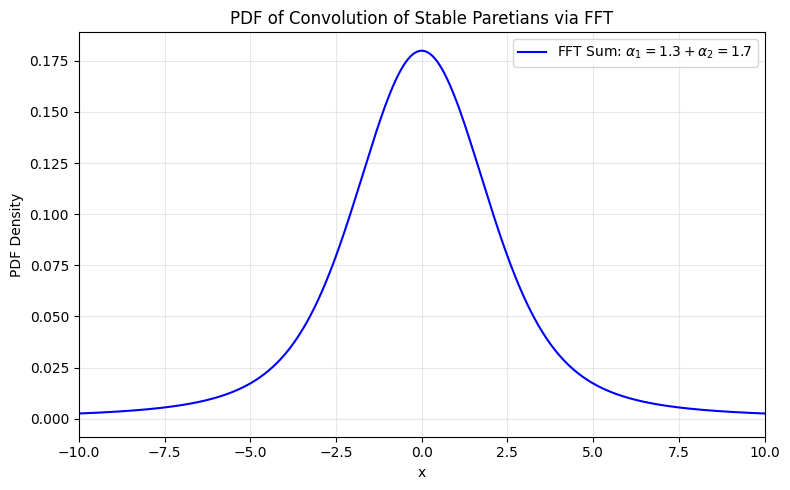

In [17]:
# Run FFT calculation- Increase x_range if the distribution has very heavy tails
x_fft, pdf_fft = fft_density_calculation(alpha_1, alpha_2, N = 16384, x_range = 40)

# Plot
plt.figure(figsize = (8, 5))
plt.plot(x_fft, pdf_fft, label=f'FFT Sum: $\\alpha_1={alpha_1} + \\alpha_2={alpha_2}$', color = 'blue')
plt.xlim(-10, 10) 
plt.xlabel('x')
plt.ylabel('PDF Density')
plt.title('PDF of Convolution of Stable Paretians via FFT')
plt.legend()
plt.grid(True, alpha = 0.3)
plt.tight_layout()
plt.show()

Overlay all the plots on a single graphic, use lovely colors, and add a legend to the graphic so I can see what is what; and be sure to use x- and y-labels, and titles in the plot. (Totally easy with an AI engine, but be sure you could do it on your own!) Note that, if you get everything correct, the densities should all be extremely close.

Make a further plot, same as before, using all 4 methods, but just for the tail, e.g., for x values between, say, 4 and 10.

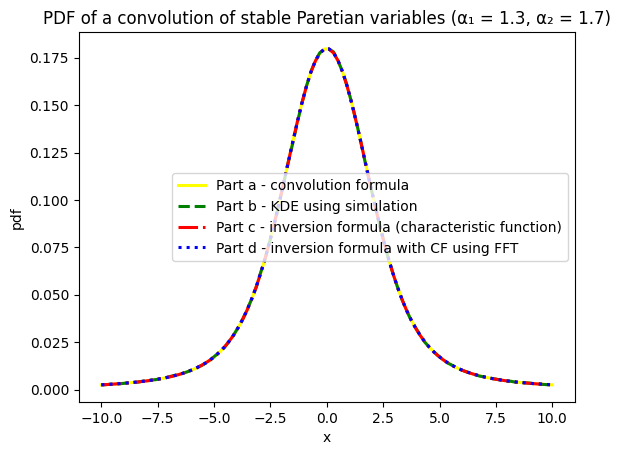

In [18]:
# centered
plt.title("PDF of a convolution of stable Paretian variables (α₁ = 1.3, α₂ = 1.7)")
plt.plot(x_line, y, label = "Part a - convolution formula", color = "yellow", linewidth = 2.2, linestyle = "-")
plt.plot(x_line, kde_vals, label = "Part b - KDE using simulation", color = "green", linewidth = 2.2, linestyle = "--")
plt.plot(x_line, phi_1, label = "Part c - inversion formula (characteristic function)", color = "red", linewidth = 2.2, linestyle = "-.")
pdf_fft_aligned = np.interp(x_line, x_fft, pdf_fft)
plt.plot(x_line, pdf_fft_aligned, label = "Part d - inversion formula with CF using FFT", color = "blue", linewidth = 2.2, linestyle = ":")
plt.legend()
plt.xlabel("x")
plt.ylabel("pdf")
plt.show()

In [19]:
print(y[-30:])

[0.02859257 0.02525447 0.02236246 0.01985897 0.01769159 0.01581355
 0.01418372 0.01276635 0.01153064 0.01045024 0.00950272 0.00866904
 0.00793309 0.00728121 0.00670187 0.00618528 0.00572316 0.00530845
 0.00493515 0.00459814 0.00429302 0.00401602 0.00376389 0.00353383
 0.00332341 0.0031305  0.00295326 0.00279009 0.00263956 0.00250043]


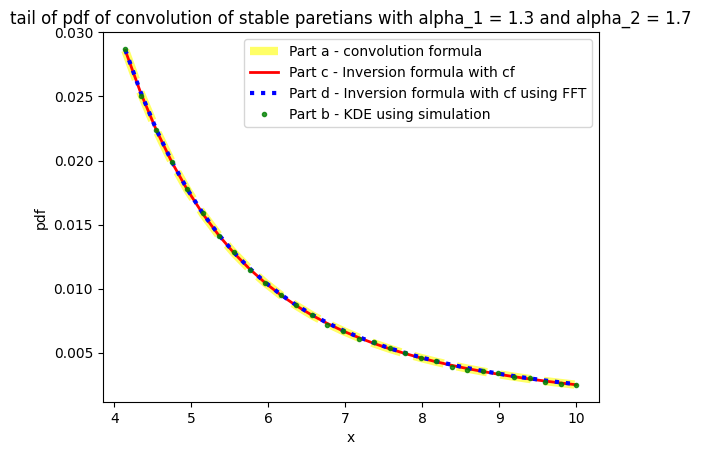

In [20]:
# Tails 
x_line_tails = [x for x in x_line if x >= 4]
n_tail = len(x_line_tails)
plt.title("tail of pdf of convolution of stable paretians with alpha_1 = 1.3 and alpha_2 = 1.7")
plt.plot(x_line_tails, y[-n_tail:], label = "Part a - convolution formula", 
         linestyle = '--', linewidth = 6, color = "yellow", alpha = 0.6)
plt.plot(x_line_tails, phi_1[-n_tail:], label = "Part c - Inversion formula with cf", 
         linestyle = '-', linewidth = 2, color = "red")
pdf_fft_aligned = np.interp(x_line_tails, x_fft, pdf_fft)
plt.plot(x_line_tails, pdf_fft_aligned, label = 'Part d - Inversion formula with cf using FFT', 
         linestyle = ':', linewidth = 3, color='blue')
plt.plot(x_line_tails, kde_vals[-n_tail:], label = 'Part b - KDE using simulation', 
         linestyle = 'None', marker = 'o', markersize = 3, color = "green", alpha = 0.8)

plt.xlabel("x")
plt.ylabel("pdf")
plt.legend()
plt.show()

# PART 2

Via simulation, compute the sum of two independent symmetric stable variates. Note that simulation of the stable is very fast. For alpha2, use 1.8. For alpha1, use a grid of, say, 5 or 6 values, on [1.2, 1.8]. Notice when you use alpha1=1.8, we are summing independent stables with the same alpha tail index, so its distribution is stable with alpha = 1.8.

Our goal is to *estimate the tail index of the sum*. This sounds like maximum likelihood, and very slow computation. However, because we are in a simple, IID framework (e.g., there is no parametric model, such as regression or GARCH or ARMA), we can use another method that is super fast, and super accurate, and for which I will give you the codes in Matlab. See attached. If you insist on using Python, you will have to convert it, or search the web for it. We only use stableregkw.m. It calls stablecull.m, also attached.

In Matlab, you can call:
pd1 = makedist('Stable','alpha',1.8,'beta',0,'gam',1,'delta',0);
X1 = random(pd1,5000,1);
[alpha,beta,sigma,mu]=stableregkw(X1)

to confirm it works.

You simulate, say, n=1000 observations from the aforementioned sum of stables. Notice you will have 5 or 6 of these, from the values of the alpha1 parameter. Pretend the sum is stable (it is not, unless alpha1=1.8; right?). Estimate the 4 distributional parameters using stableregkw. It is super fast. The values obtained for one simulation are not interesting. Repeat this sim=500 times, and then generate boxplots of the resulting parameter estimates. Notice you get one box plot for each value in the grid of alpha1 values. Right? Make nice, labeled, smart boxplots, using the features of Matlab or Python.

Now repeat, with n=10,000.

For both sample sizes, and from the grid of 5 or 6 of alpha1: For each of your sim=500 trials, use the non-parametric bootstrap to calculate a 90% confidence interval (CI) of the alpha parameter (do not bother doing so for the other 3 parameters of the stable distribution). For each of the sim=500 trials, you get one confidence interval of alpha. For each, compute its length. From these 500 CIs, and for the 2 sample sizes, and for the 5-6 grid of alpha1 values, now make a histogram of the lengths.

In [21]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import linregress

# ==========================================
# 1. STABLECULL (McCulloch's Method)
# ==========================================
def stablecull(x):
    """
    Python implementation of stablecull (McCulloch's Quantile Method).
    Estimates alpha, beta, sigma, mu using 5 quantiles.
    """
    x = np.array(x).flatten()
    
    # 1. Compute Quantiles [5, 25, 50, 75, 95]
    q = np.percentile(x, [5, 25, 50, 75, 95])
    x05, x25, x50, x75, x95 = q
    
    # 2. Compute Quantile Statistics
    denom_va = (x75 - x25)
    if denom_va == 0: denom_va = 1e-10 # Safety
    
    denom_vb = (x95 - x05)
    if denom_vb == 0: denom_vb = 1e-10 # Safety
    
    va = (x95 - x05) / denom_va
    vb = (x95 + x05 - 2 * x50) / denom_vb
    vs = x75 - x25
    
    # 3. Lookup Tables (Hardcoded from MATLAB source / McCulloch 1986)
    tva = np.array([2.439, 2.5, 2.6, 2.7, 2.8, 3.0, 3.2, 3.5, 4.0, 5.0, 6.0, 8.0, 10.0, 15.0, 25.0])
    tvb = np.array([0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0])
    ta  = np.array([2.0, 1.9, 1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5])
    tb  = np.array([0.0, 0.25, 0.5, 0.75, 1.0])

    psi1 = np.array([[2.000, 2.000, 2.000, 2.000, 2.000, 2.000, 2.000],
                     [1.916, 1.924, 1.924, 1.924, 1.924, 1.924, 1.924],
                     [1.808, 1.813, 1.829, 1.829, 1.829, 1.829, 1.829],
                     [1.729, 1.730, 1.737, 1.745, 1.745, 1.745, 1.745],
                     [1.664, 1.663, 1.663, 1.668, 1.676, 1.676, 1.676],
                     [1.563, 1.560, 1.553, 1.548, 1.547, 1.547, 1.547],
                     [1.484, 1.480, 1.471, 1.460, 1.448, 1.438, 1.438],
                     [1.391, 1.386, 1.378, 1.364, 1.337, 1.318, 1.318],
                     [1.279, 1.273, 1.266, 1.250, 1.210, 1.184, 1.150],
                     [1.128, 1.121, 1.114, 1.101, 1.067, 1.027, 0.973],
                     [1.029, 1.021, 1.014, 1.004, 0.974, 0.935, 0.874],
                     [0.896, 0.892, 0.887, 0.883, 0.855, 0.823, 0.769],
                     [0.818, 0.812, 0.806, 0.801, 0.780, 0.756, 0.691],
                     [0.698, 0.695, 0.692, 0.689, 0.676, 0.656, 0.595],
                     [0.593, 0.590, 0.588, 0.586, 0.579, 0.563, 0.513]])

    psi2 = np.array([[0.000, 2.160, 1.000, 1.000, 1.000, 1.000, 1.000],
                     [0.000, 1.592, 3.390, 1.000, 1.000, 1.000, 1.000],
                     [0.000, 0.759, 1.800, 1.000, 1.000, 1.000, 1.000],
                     [0.000, 0.482, 1.048, 1.694, 1.000, 1.000, 1.000],
                     [0.000, 0.360, 0.760, 1.232, 2.229, 1.000, 1.000],
                     [0.000, 0.253, 0.518, 0.823, 1.575, 1.000, 1.000],
                     [0.000, 0.203, 0.410, 0.632, 1.244, 1.906, 1.000],
                     [0.000, 0.165, 0.332, 0.499, 0.943, 1.560, 1.000],
                     [0.000, 0.136, 0.271, 0.404, 0.689, 1.230, 2.195],
                     [0.000, 0.109, 0.216, 0.323, 0.539, 0.827, 1.917],
                     [0.000, 0.096, 0.190, 0.284, 0.472, 0.693, 1.759],
                     [0.000, 0.082, 0.163, 0.243, 0.412, 0.601, 1.596],
                     [0.000, 0.074, 0.147, 0.220, 0.377, 0.546, 1.482],
                     [0.000, 0.064, 0.128, 0.191, 0.330, 0.478, 1.362],
                     [0.000, 0.056, 0.112, 0.167, 0.285, 0.428, 1.274]])

    psi3 = np.array([[1.908, 1.908, 1.908, 1.908, 1.908],
                     [1.914, 1.915, 1.916, 1.918, 1.921],
                     [1.921, 1.922, 1.927, 1.936, 1.947],
                     [1.927, 1.930, 1.943, 1.961, 1.987],
                     [1.933, 1.940, 1.962, 1.997, 2.043],
                     [1.939, 1.952, 1.988, 2.045, 2.116],
                     [1.946, 1.967, 2.022, 2.106, 2.211],
                     [1.955, 1.984, 2.067, 2.188, 2.333],
                     [1.965, 2.007, 2.125, 2.294, 2.491],
                     [1.980, 2.040, 2.205, 2.435, 2.696],
                     [2.000, 2.085, 2.311, 2.624, 2.973],
                     [2.040, 2.149, 2.461, 2.886, 3.356],
                     [2.098, 2.244, 2.676, 3.265, 3.912],
                     [2.189, 2.392, 3.004, 3.844, 4.775],
                     [2.337, 2.635, 3.542, 4.808, 6.247],
                     [2.588, 3.073, 4.534, 6.636, 9.144]])

    psi4 = np.array([[0.0, 0.0, 0.0, 0.0, 0.0],
                     [0.0, -0.017, -0.032, -0.049, -0.064],
                     [0.0, -0.030, -0.061, -0.092, -0.123],
                     [0.0, -0.043, -0.088, -0.132, -0.179],
                     [0.0, -0.056, -0.111, -0.170, -0.232],
                     [0.0, -0.066, -0.134, -0.206, -0.283],
                     [0.0, -0.075, -0.154, -0.241, -0.335],
                     [0.0, -0.084, -0.173, -0.276, -0.390],
                     [0.0, -0.090, -0.192, -0.310, -0.447],
                     [0.0, -0.095, -0.208, -0.346, -0.508],
                     [0.0, -0.098, -0.223, -0.383, -0.576],
                     [0.0, -0.099, -0.237, -0.424, -0.652],
                     [0.0, -0.096, -0.250, -0.469, -0.742],
                     [0.0, -0.089, -0.262, -0.520, -0.853],
                     [0.0, -0.078, -0.272, -0.581, -0.997],
                     [0.0, -0.061, -0.279, -0.659, -1.198]])

    # 4. Interpolate Parameters
    # Using scipy RegularGridInterpolator for bilinear interpolation
    interp_psi1 = RegularGridInterpolator((tva, tvb), psi1, bounds_error=False, fill_value=None)
    interp_psi2 = RegularGridInterpolator((tva, tvb), psi2, bounds_error=False, fill_value=None)
    
    # Clip inputs to table bounds
    va_c = np.clip(va, tva[0], tva[-1])
    vb_c = np.clip(np.abs(vb), tvb[0], tvb[-1])
    
    alpha_est = interp_psi1((va_c, vb_c))
    beta_est  = interp_psi2((va_c, vb_c)) * np.sign(vb)
    
    # Interpolate Sigma and Mu
    # Note: 'ta' is descending. Flip for scipy interpolator
    ta_asc = ta[::-1]
    psi3_asc = psi3[::-1, :]
    psi4_asc = psi4[::-1, :]
    
    interp_psi3 = RegularGridInterpolator((ta_asc, tb), psi3_asc, bounds_error=False, fill_value=None)
    interp_psi4 = RegularGridInterpolator((ta_asc, tb), psi4_asc, bounds_error=False, fill_value=None)
    
    alpha_c = np.clip(alpha_est, ta_asc[0], ta_asc[-1])
    beta_c  = np.clip(np.abs(beta_est), tb[0], tb[-1])
    
    sigma_est = vs / interp_psi3((alpha_c, beta_c))
    zeta = sigma_est * interp_psi4((alpha_c, beta_c)) * np.sign(beta_est) + x50
    
    if np.abs(alpha_est - 1.0) < 0.05:
        mu_est = zeta
    else:
        mu_est = zeta - beta_est * sigma_est * np.tan(0.5 * np.pi * alpha_est)
        
    return float(alpha_est), float(beta_est), float(sigma_est), float(mu_est)

# ==========================================
# 2. STABLEREGKW (Kogon-Williams Regression)
# ==========================================
def stableregkw(x, deltac=None):
    """
    Python implementation of stableregkw.
    Estimates Stable parameters using regression on the characteristic function.
    Calls stablecull for initialization.
    """
    x = np.array(x).flatten()
    if deltac is None:
        deltac = np.arange(100) # Default grid
        
    # 1. INITIALIZATION via stablecull
    alpha0, beta0, sigma0, mu0 = stablecull(x)
    
    # 2. Convert to S0 parametrization for regression stability
    mu_S0 = mu0 + beta0 * sigma0 * np.tan(0.5 * np.pi * alpha0)
    x_std = (x - mu_S0) / sigma0
    
    # 3. Setup Regression Grids
    t = np.linspace(0.1, 1.0, 10)
    u = t
    w = np.log(np.abs(t))
    w1 = w - np.mean(w)
    
    # 4. Compute ECF
    phi = np.mean(np.exp(1j * np.outer(t, x_std)), axis=1)
    
    # 5. Alpha Estimation
    # Model: log(-2 * log|phi|)
    # Use clip to avoid log(0)
    val = -2 * np.log(np.abs(phi))
    val = np.maximum(val, 1e-10) # Safety
    y = np.log(val)
    
    # Weighted slope
    alpha1 = np.sum(w1 * (y - np.mean(y))) / np.sum(w1 * w1)
    
    # Recalculate scaling c1
    c1 = (0.5 * np.exp(np.mean(y - alpha1 * w))) ** (1/alpha1)
    X_reg = x_std / c1
    
    # 6. Beta & Mu Estimation (Search Method)
    sinXu = []
    cosXu = []
    for uu in u:
        uuX = uu * X_reg
        sinXu.append(np.sum(np.sin(uuX)))
        cosXu.append(np.sum(np.cos(uuX)))
    
    sinXu = np.array(sinXu)
    cosXu = np.array(cosXu)
    
    # Broadcasting for search grid
    dc_grid = deltac[:, np.newaxis]
    u_grid = u[np.newaxis, :]
    
    term1 = cosXu * np.cos(dc_grid * u_grid)
    term2 = sinXu * np.sin(dc_grid * u_grid)
    testcos = term1 + term2
    
    # Find index of minimal sign flips (stability)
    sign_flips = np.sum(np.abs(np.diff(np.sign(testcos), axis=1)), axis=1)
    best_idx = np.argmin(sign_flips)
    deltac_opt = deltac[best_idx]
    
    # Final Regression for Beta/Delta
    X_shifted = X_reg - deltac_opt
    num = sinXu * np.cos(deltac_opt) - cosXu * np.sin(deltac_opt)
    den = cosXu * np.cos(deltac_opt) + sinXu * np.sin(deltac_opt)
    z_val = np.arctan(num / den)
    
    y_val = (c1 ** alpha1) * np.tan(np.pi * alpha1 / 2) * np.sign(u) * (u ** alpha1)
    
    sum_uu = np.sum(u * u)
    sum_yy = np.sum(y_val * y_val)
    sum_uy = np.sum(u * y_val)
    sum_uz = np.sum(u * z_val)
    sum_yz = np.sum(y_val * z_val)
    
    denom = (sum_uu * sum_yy) - (sum_uy ** 2)
    delta2 = (sum_yy * sum_uz - sum_uy * sum_yz) / denom
    beta2  = (sum_uu * sum_yz - sum_uy * sum_uz) / denom
    
    # 7. Update Parameters
    sigma_final = sigma0 * c1
    mu_final = mu0 + deltac_opt * sigma_final
    alpha_final = alpha1
    beta_final = beta2
    
    mu_final = mu_final + sigma_final * delta2
    mu_final = mu_final + beta_final * sigma_final * np.tan(0.5 * np.pi * alpha_final)
    
    # 8. Clamps
    alpha_final = np.clip(alpha_final, 0.1, 2.0)
    beta_final = np.clip(beta_final, -1.0, 1.0)
    sigma_final = np.maximum(sigma_final, 1e-10)
    
    return float(alpha_final), float(beta_final), float(sigma_final), float(mu_final)



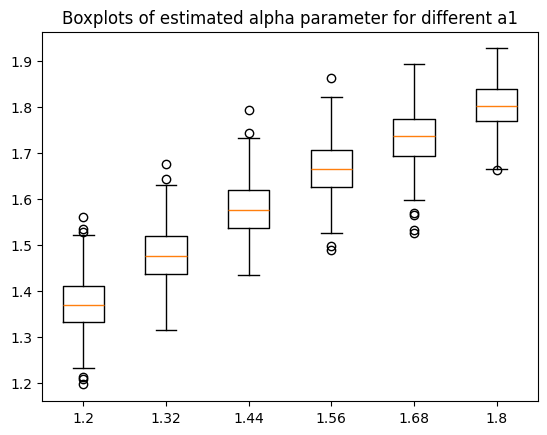

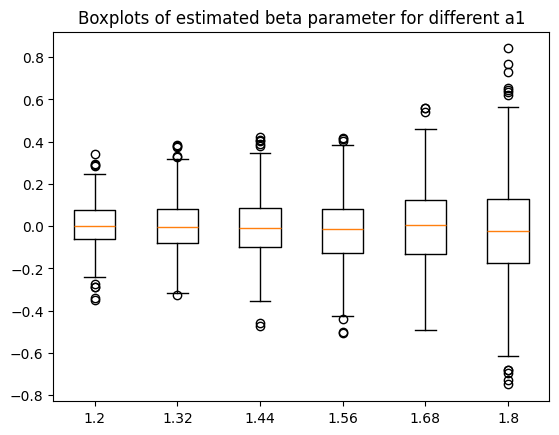

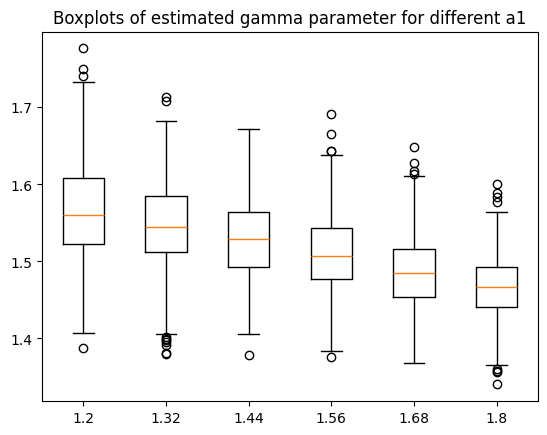

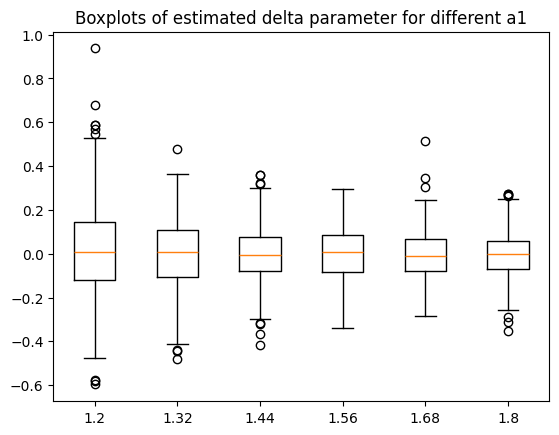

In [22]:
alpha_2 = 1.8
alpha_1_array = [1.2, 1.32, 1.44, 1.56, 1.68, 1.8]
n = 1000
sims = 500
a_total1k, b_total1k, g_total1k, d_total1k = [], [], [], []
samples_1k = {val: [] for val in alpha_1_array}

for alpha_1 in alpha_1_array:
    alphas, betas, gammas, deltas = [], [], [], []
    for i in range(sims):
        sample_1 = levy_stable.rvs(alpha_1, 0, size = n)
        sample_2 = levy_stable.rvs(alpha_2, 0, size = n)
        s = sample_1 + sample_2
        
        samples_1k[alpha_1].append(s)
        
        a, b, g, d, = stableregkw(s)
        alphas.append(a)
        betas.append(b)
        gammas.append(g)
        deltas.append(d)
    a_total1k.append(alphas)
    b_total1k.append(betas)
    g_total1k.append(gammas)
    d_total1k.append(deltas)

plt.boxplot(a_total1k, tick_labels = alpha_1_array)
plt.title("Boxplots of estimated alpha parameter for different a1")
plt.show()
plt.boxplot(b_total1k, tick_labels = alpha_1_array)
plt.title("Boxplots of estimated beta parameter for different a1")
plt.show()
plt.boxplot(g_total1k, tick_labels = alpha_1_array)
plt.title("Boxplots of estimated gamma parameter for different a1")
plt.show()
plt.boxplot(d_total1k, tick_labels = alpha_1_array)
plt.title("Boxplots of estimated delta parameter for different a1")
plt.show()

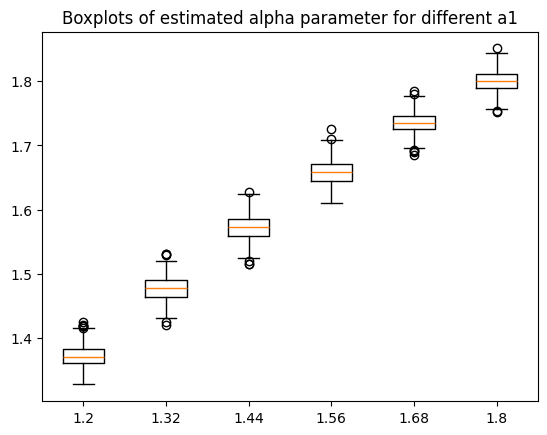

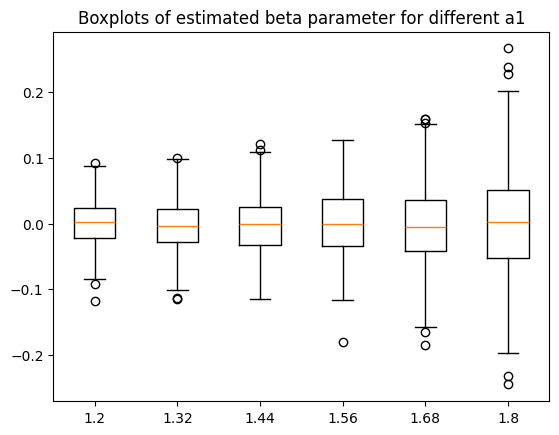

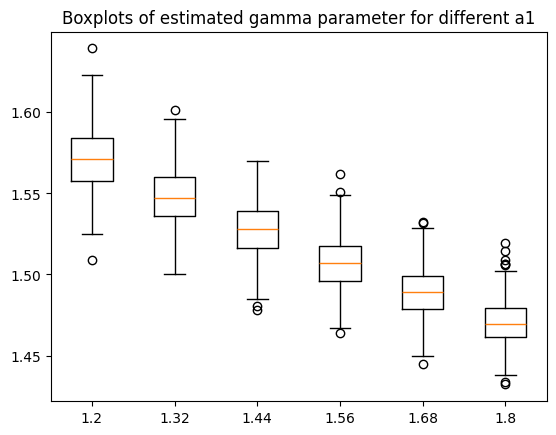

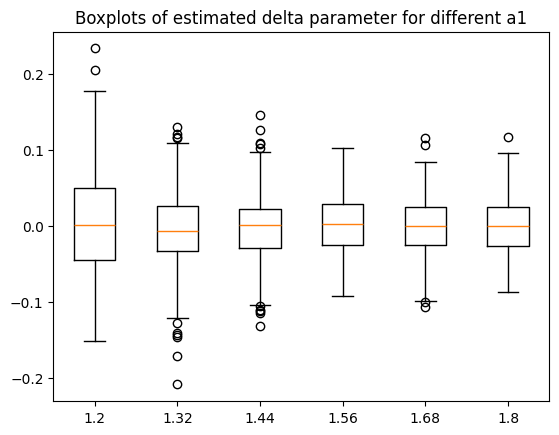

In [23]:
alpha_2 = 1.8
alpha_1_array = [1.2, 1.32, 1.44, 1.56, 1.68, 1.8]
n = 10000
sims = 500
a_total10k, b_total10k, g_total10k, d_total10k = [], [], [], []
samples_10k = {val: [] for val in alpha_1_array}

for alpha_1 in alpha_1_array:
    alphas, betas, gammas, deltas = [], [], [], []
    for i in range(sims):
        sample_1 = levy_stable.rvs(alpha_1, 0, size = n)
        sample_2 = levy_stable.rvs(alpha_2, 0, size = n)
        s = sample_1 + sample_2
        
        samples_10k[alpha_1].append(s)
        
        a, b, g, d, = stableregkw(s)
        alphas.append(a)
        betas.append(b)
        gammas.append(g)
        deltas.append(d)
    a_total10k.append(alphas)
    b_total10k.append(betas)
    g_total10k.append(gammas)
    d_total10k.append(deltas)

plt.boxplot(a_total10k, tick_labels = alpha_1_array)
plt.title("Boxplots of estimated alpha parameter for different a1")
plt.show()
plt.boxplot(b_total10k, tick_labels = alpha_1_array)
plt.title("Boxplots of estimated beta parameter for different a1")
plt.show()
plt.boxplot(g_total10k, tick_labels = alpha_1_array)
plt.title("Boxplots of estimated gamma parameter for different a1")
plt.show()
plt.boxplot(d_total10k, tick_labels = alpha_1_array)
plt.title("Boxplots of estimated delta parameter for different a1")
plt.show()

In [24]:
B = 500  # Number of bootstrap resamples. Increase for more precision (e.g., 100 or 500), but it will take longer.
ci_level = 0.90
lower_p = (1 - ci_level) / 2 * 100
upper_p = (1 + ci_level) / 2 * 100

# Containers to store CI lengths
# Structure: {alpha_value: [list of 500 CI lengths]}
ci_results_1k = {a: [] for a in alpha_1_array}
ci_results_10k = {a: [] for a in alpha_1_array}

# Group datasets for iteration
# We assume samples_1k and samples_10k are now DICTIONARIES {alpha_val: [list_of_samples]}
datasets = [
    ("N=1000", samples_1k, ci_results_1k),
    ("N=10000", samples_10k, ci_results_10k)
]

print(f"Starting Bootstrap Analysis (B={B}, Sims={sims})...")

for label, data_source, result_dict in datasets:
    print(f"Processing {label}...")
    
    # Iterate through each alpha in the grid
    for idx_a, alpha_val in enumerate(alpha_1_array):
        
        # CHANGED: Access samples directly from dictionary by key
        # No more slicing needed
        current_samples = data_source[alpha_val]
        
        print(f"  > Alpha = {alpha_val}")
        
        # Iterate through each of the 500 trials
        for sample in current_samples:
            boot_alphas = []
            
            # Perform Bootstrap
            for _ in range(B):
                # Resample with replacement
                resample = np.random.choice(sample, size=len(sample), replace=True)
                
                # Estimate Alpha only
                a_est, _, _, _ = stableregkw(resample)
                boot_alphas.append(a_est)
            
            # Calculate 90% Confidence Interval
            ci_low = np.percentile(boot_alphas, lower_p)
            ci_high = np.percentile(boot_alphas, upper_p)
            
            # Store Length
            length = ci_high - ci_low
            result_dict[alpha_val].append(length)





Starting Bootstrap Analysis (B=500, Sims=500)...
Processing N=1000...
  > Alpha = 1.2


KeyboardInterrupt: 

In [ ]:
# standardize the y axis

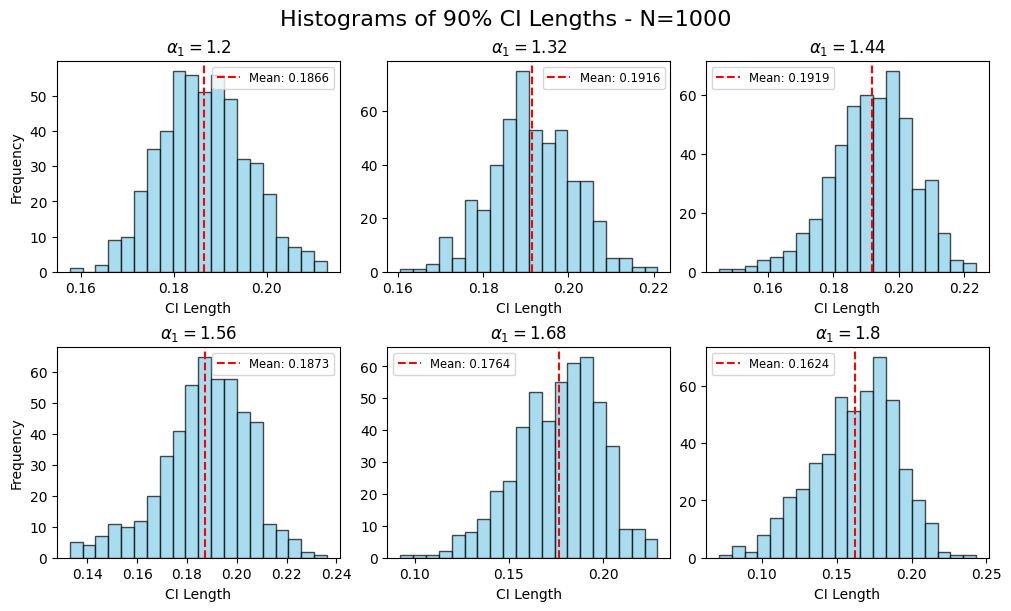

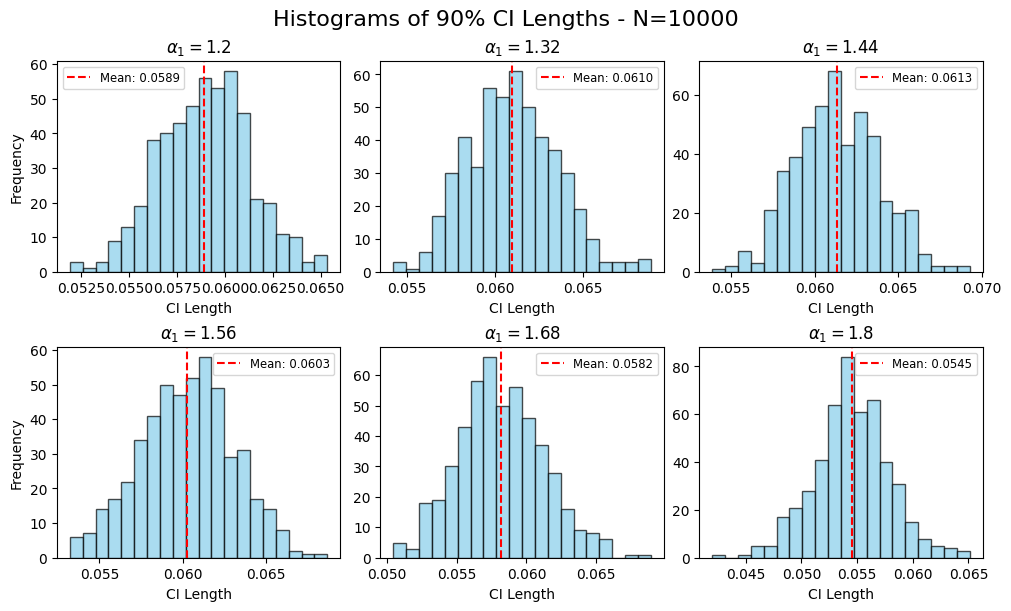

In [ ]:
for label, _, result_dict in datasets:
    fig, axes = plt.subplots(2, 3, figsize=(10, 6), constrained_layout=True)
    fig.suptitle(f"Histograms of 90% CI Lengths - {label}", fontsize=16)
    
    axes_flat = axes.flatten()
    
    for i, alpha_val in enumerate(alpha_1_array):
        ax = axes_flat[i]
        lengths = result_dict[alpha_val]
        
        # Plot Histogram
        ax.hist(lengths, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
        
        # Statistics
        mean_len = np.mean(lengths)
        
        ax.set_title(f"$\\alpha_1 = {alpha_val}$")
        ax.set_xlabel("CI Length")
        ax.axvline(mean_len, color='red', linestyle='--', label=f'Mean: {mean_len:.4f}')
        ax.legend(fontsize='small')
        
        if i % 3 == 0:
            ax.set_ylabel("Frequency")

    plt.show()

# Part 3

In [25]:
def neg_log_likelihood(params, data):
    alpha, gamma, delta = params
    pdf_values = levy_stable.pdf(data, alpha, beta = 0, loc = gamma, scale = delta)
    #pdf_values = np.maximum(pdf_values, 1e-10) # Prevent log(0) -> -inf by setting a tiny lower bound
    return -np.sum(np.log(pdf_values))
data = levy_stable.rvs(alpha = 1.5, beta = 0, loc = 0, scale = 1, size = 10000)

# Initial guess: [alpha, gamma, delta]
x0 = [1.7, 0.5, 2.0] 

# whwere did we choose bounds from?
bounds = [(1., 2.0), (None, None), (1e-3, None)]

res = minimize(neg_log_likelihood, x0, args=(data,), method='L-BFGS-B', bounds=bounds)#options={'ftol': 1e-9}
print(f"Success: {res.success}")
print(f"Optimized Parameters: alpha={res.x[0]:.4f}, gamma={res.x[1]:.4f}, delta={res.x[2]:.4f}")

Success: True
Optimized Parameters: alpha=1.4980, gamma=0.0114, delta=1.0010


In [27]:
def neg_log_likelihood_mixture(params, data):
    alpha1, gamma1, delta1, alpha2, gamma2, delta2, weight  = params

    pdf_values = weight * levy_stable.pdf(data, alpha1, beta = 0, loc = gamma1, scale = delta1) + (1-weight) * levy_stable.pdf(data, alpha2, beta = 0, loc = gamma2, scale = delta2)
    # pdf_values =  min(levy_stable.pdf(data, alpha1, beta=0, loc=gamma1, scale=delta1), levy_stable.pdf(data, alpha2, beta=0, loc=gamma2, scale=delta2))
    pdf_values = np.clip(pdf_values, 1e-300, np.inf) # Prevents log(0) = -inf
    
    return -np.sum(np.log(pdf_values))

data = []
size = 1000
alpha1, gamma1, delta1 = 1.2, 0.5, 0.5,
alpha2, gamma2, delta2 = 1.7, -0.1, 1.,
weight  = 0.4

for _ in range(size):
    if np.random.uniform() < weight:
        data_point = levy_stable.rvs(alpha1, 0, gamma1, delta1)
    else:
        data_point = levy_stable.rvs(alpha2, 0, gamma2, delta2)
    
    data.append(data_point)

data = np.array(data)

# Initial guess: [alpha, gamma, delta]
x0 = [1.3, 0.5, 2.0, 1.6, 0.5, 2.5, 0.5]

# 4. Use L-BFGS-B to handle bounds
# Alpha: (1., 2.0), Gamma: No bounds, Delta: (0.001, +inf)
sample_mean = data.mean()
sample_var = data.std()
bounds = [(1., 2.0), (None, None), (1e-3, 20* np.sqrt(sample_var)), (1., 2.0), (None, None), (1e-3, 20* np.sqrt(sample_var)), (0, 1)]

In [28]:
res = minimize(
    neg_log_likelihood_mixture, x0, args = (data,), method = 'L-BFGS-B',bounds = bounds)#options = {'ftol': 1e-9}

#Summary Output
print(f"Success: {res.success}")
print(f"Message: {res.message}")
print("-" * 30)
print(f"True Params:")
print(f"Dist 1: alpha={alpha1}, loc={gamma1}, scale={delta1}")
print(f"Dist 2: alpha={alpha2}, loc={gamma2}, scale={delta2}")
print(f"Weight: {weight}")
print("-" * 30)
print(f"Estimated Params:")
p = res.x
print(f"Dist 1: a={p[0]:.3f}, loc={p[1]:.3f}, scale={p[2]:.3f}")
print(f"Dist 2: a={p[3]:.3f}, loc={p[4]:.3f}, scale={p[5]:.3f}")
print(f"Weight: {p[6]:.3f}")

Success: True
Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
------------------------------
True Params:
Dist 1: alpha=1.2, loc=0.5, scale=0.5
Dist 2: alpha=1.7, loc=-0.1, scale=1.0
Weight: 0.4
------------------------------
Estimated Params:
Dist 1: a=1.222, loc=0.447, scale=0.603
Dist 2: a=1.577, loc=-0.128, scale=1.055
Weight: 0.454


The "Local Optima" Trap
The likelihood landscape of a mixture model is extremely rugged with many local minima.

The solution where Weight = 1 (using only one distribution to fit the data) is a very deep, stable local minimum.

Unless your initial guess x0 is extremely close to the true separate parameters, a gradient-based optimizer (like L-BFGS-B) will almost always slide into the "single distribution" pit because it's the easiest path to improve the likelihood.

In [29]:
subset_size = 8000
colnames = ["stock "+str(i+1) for i in range(1)]
data = pd.read_csv("DJIA30stockreturns.csv", names = colnames)
results_list = []

print(f"Starting estimation on {len(data.columns)} stocks with subset size {subset_size}...")

for col in data.columns:
    print(f"Processing {col}...", end=" ")
    # replace = False ensures we pick unique points if subset_size < total rows
    stock_data = data[col].sample(n = subset_size, replace = False, random_state = 42).values
    
    # Calculate sample statistics for dynamic bounds/guesses
    s_mean = np.mean(stock_data)
    s_std = np.std(stock_data)
    
    # initial guess based on data statistics calculated above
    x0 = [1.5, s_mean, s_std * 0.8, 1.7, s_mean, s_std * 1.2, 0.5]

    # Alpha: (1.1, 2.0) - kept strict to ensure stability
    # Gamma: Unbounded (None)
    # Delta: Scaled to variance (0.001 to 20 * std)
    # Weight: (0, 1)
    bounds = [(1.1, 2.0), (None, None), (1e-3, 20 * s_std),(1.1, 2.0), (None, None), (1e-3, 20 * s_std),(0.1, 0.9)]

    try:
        res = minimize(neg_log_likelihood_mixture, x0, args = (stock_data,), method = 'L-BFGS-B', 
                       bounds = bounds,options = {'maxiter': 1000})
        
        # Store result
        p = res.x
        results_list.append({
            "Stock": col,
            "Success": res.success,
            "NLL": res.fun,
            "Alpha1": p[0], "Loc1": p[1], "Scale1": p[2],
            "Alpha2": p[3], "Loc2": p[4], "Scale2": p[5],
            "Weight": p[6]
        })
        print(f"Done. (Success: {res.success})")
        
    except Exception as e:
        print(f"Failed. Error: {e}")
        results_list.append({
            "Stock": col, "Success": False, "NLL": np.nan,
            "Alpha1": np.nan, "Loc1": np.nan, "Scale1": np.nan,
            "Alpha2": np.nan, "Loc2": np.nan, "Scale2": np.nan,
            "Weight": np.nan
        })

# Convert to DataFrame for easy viewing
results_df = pd.DataFrame(results_list)

print("-" * 30)
print("Estimation Complete. Results head:")
print(results_df.head())
results_df.to_csv("mixture_model_results.csv", index=False)

Starting estimation on 1 stocks with subset size 8000...
Processing stock 1... Done. (Success: True)
------------------------------
Estimation Complete. Results head:
     Stock  Success           NLL    Alpha1      Loc1    Scale1   Alpha2  \
0  stock 1     True  14085.567648  1.839691  0.053136  0.667948  1.89382   

       Loc2    Scale2    Weight  
0 -0.006476  1.336365  0.649267  
